In [1]:
import numpy as np
import os
import json
import cv2
import random
import sys
import copy
import matplotlib.pyplot as plt
import torch

import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.config.config import get_cfg

sys.path.append("../src")
from defs import ROOT, TRAIN_DATA_PATH, TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, VAL_DATA_PATH, VAL_IMAGES_PATH, VAL_MASKS_PATH
from data.prepare_masks import read_mask, process_for_dt2_visualization
from dt2.register import register_my_dataset
from dt2.visualize import visualize_dataset_dict, visualize_batch_item
from train import Trainer

In [2]:
register_my_dataset("train-dataset", {}, TRAIN_IMAGES_PATH, TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, TRAIN_DATA_PATH / "coco.json")
register_my_dataset("val-dataset", {}, VAL_IMAGES_PATH, VAL_IMAGES_PATH, VAL_MASKS_PATH, VAL_DATA_PATH / "coco.json")

In [3]:
dataset_name = "train-dataset"
metadata = MetadataCatalog.get(dataset_name)

## Raw data

In [4]:
dataset_dicts = DatasetCatalog.get(dataset_name)

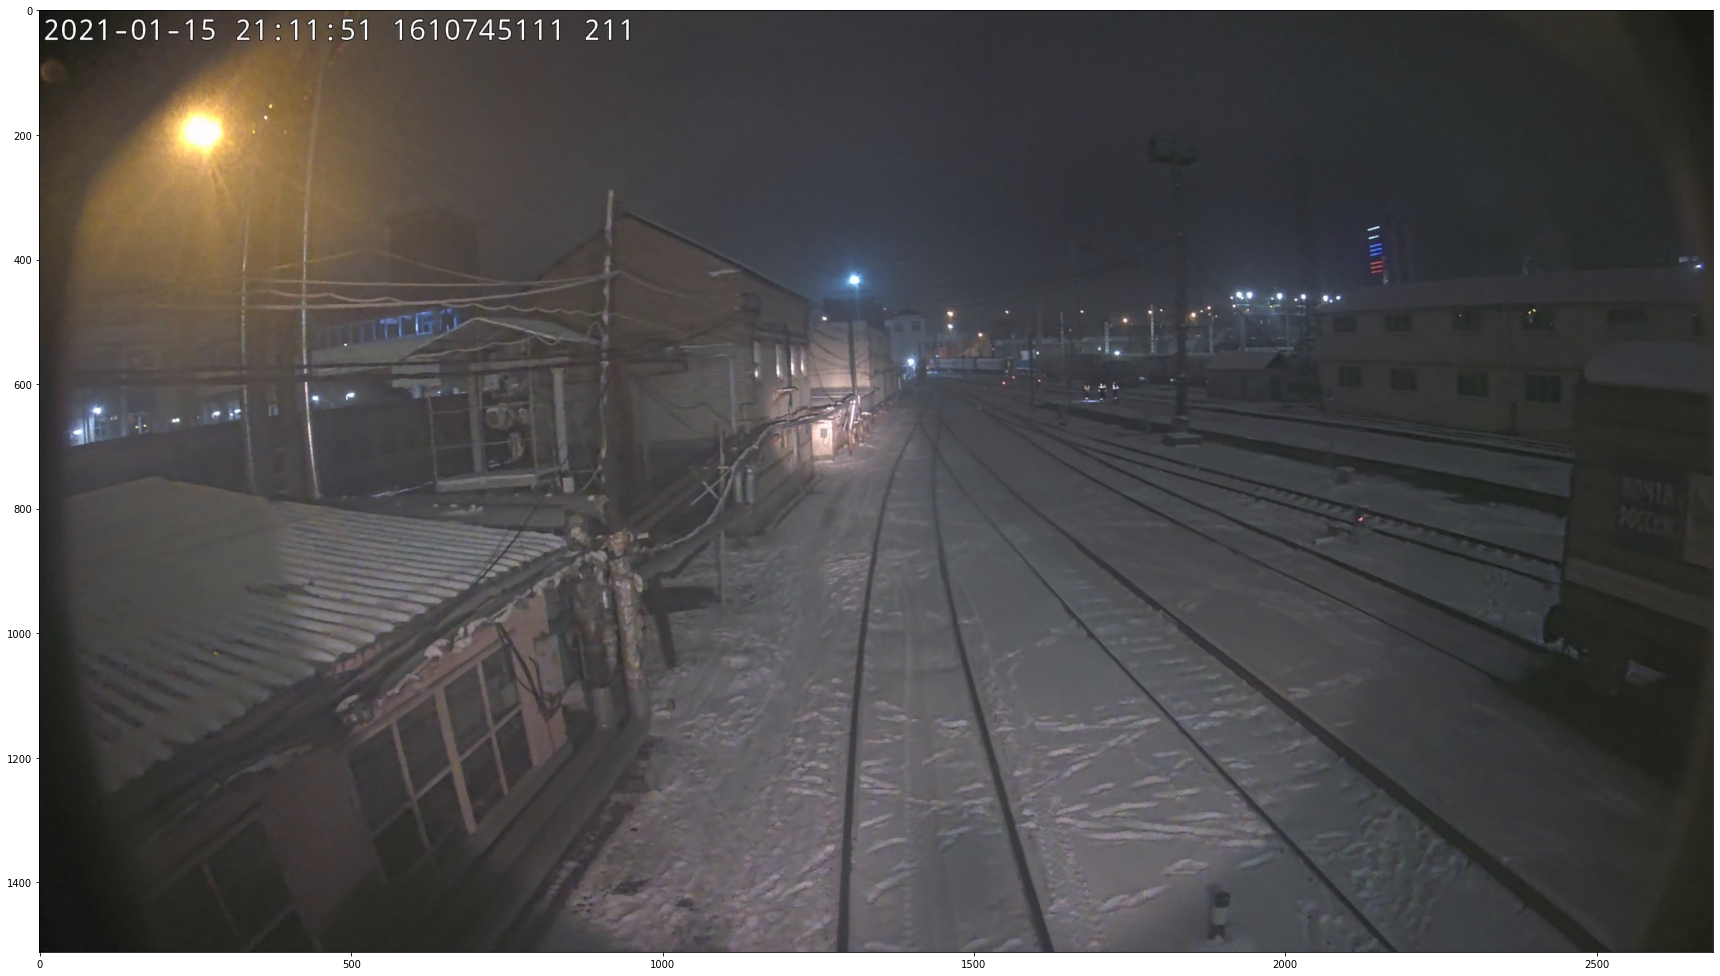

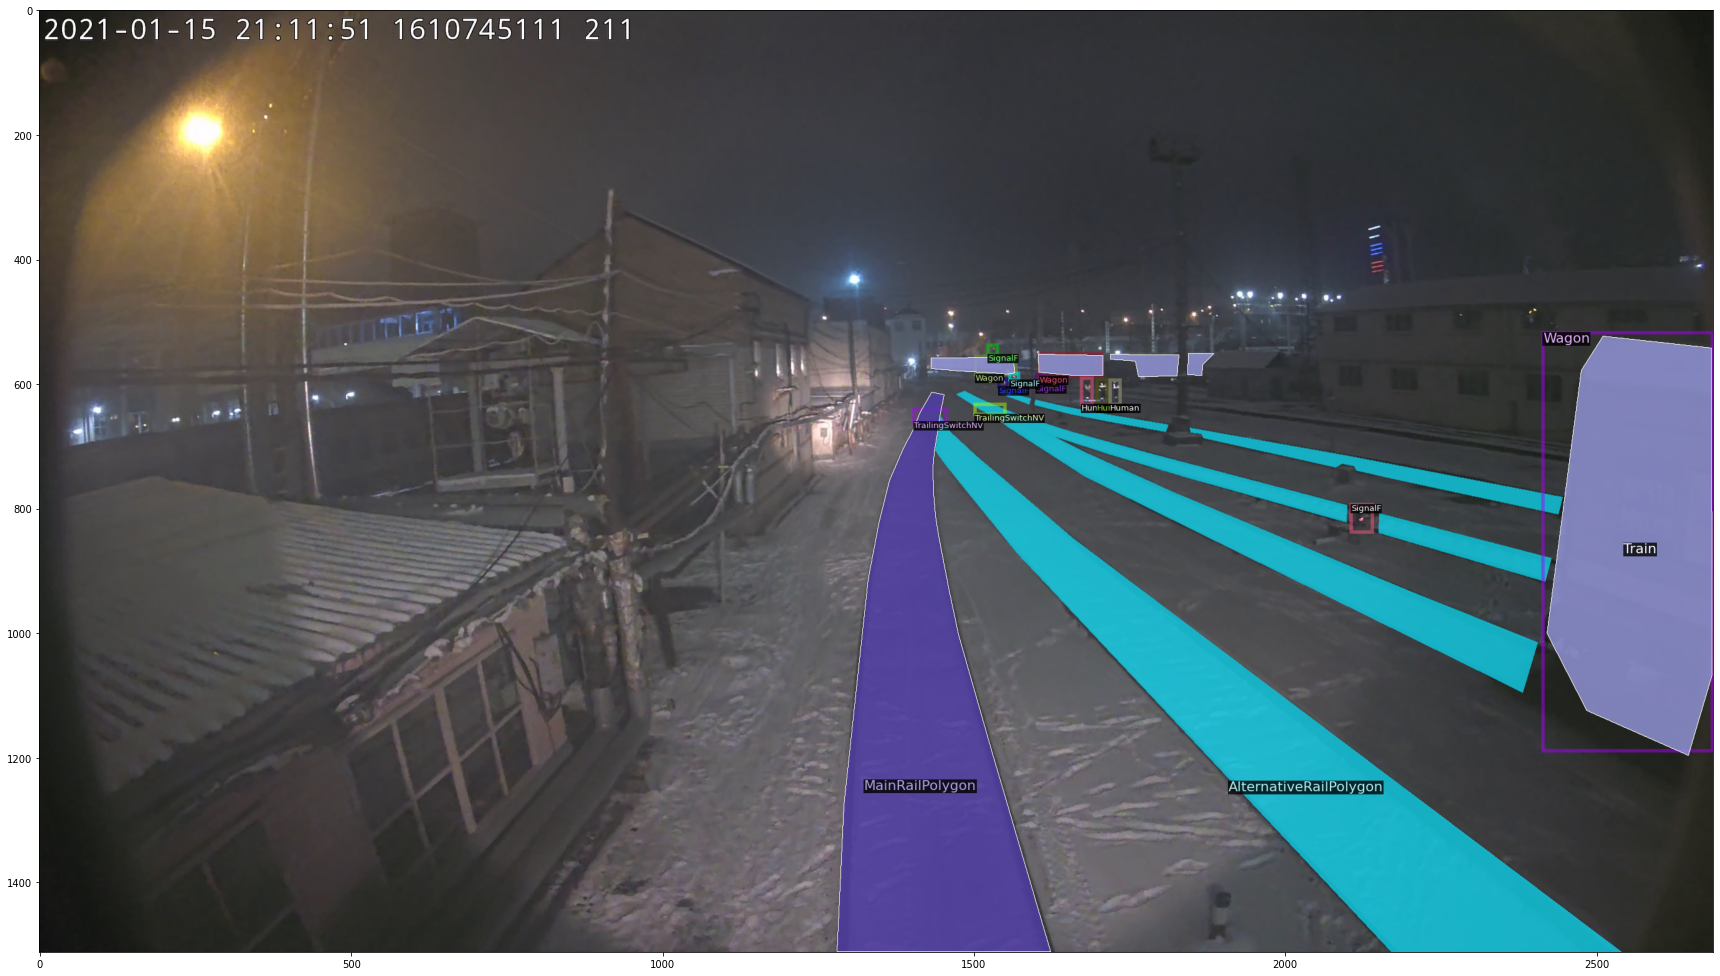

In [5]:
for d in random.sample(dataset_dicts, 1):        
    out = visualize_dataset_dict(d, metadata)

## Dataloader

In [4]:
cfg = get_cfg()
cfg.merge_from_file(ROOT / "configs" / "main.yaml")

In [5]:
dataloader = Trainer.build_train_loader(cfg)
#dataloader = Trainer.build_test_loader(cfg, "val-dataset")
dataloader_it = iter(dataloader)

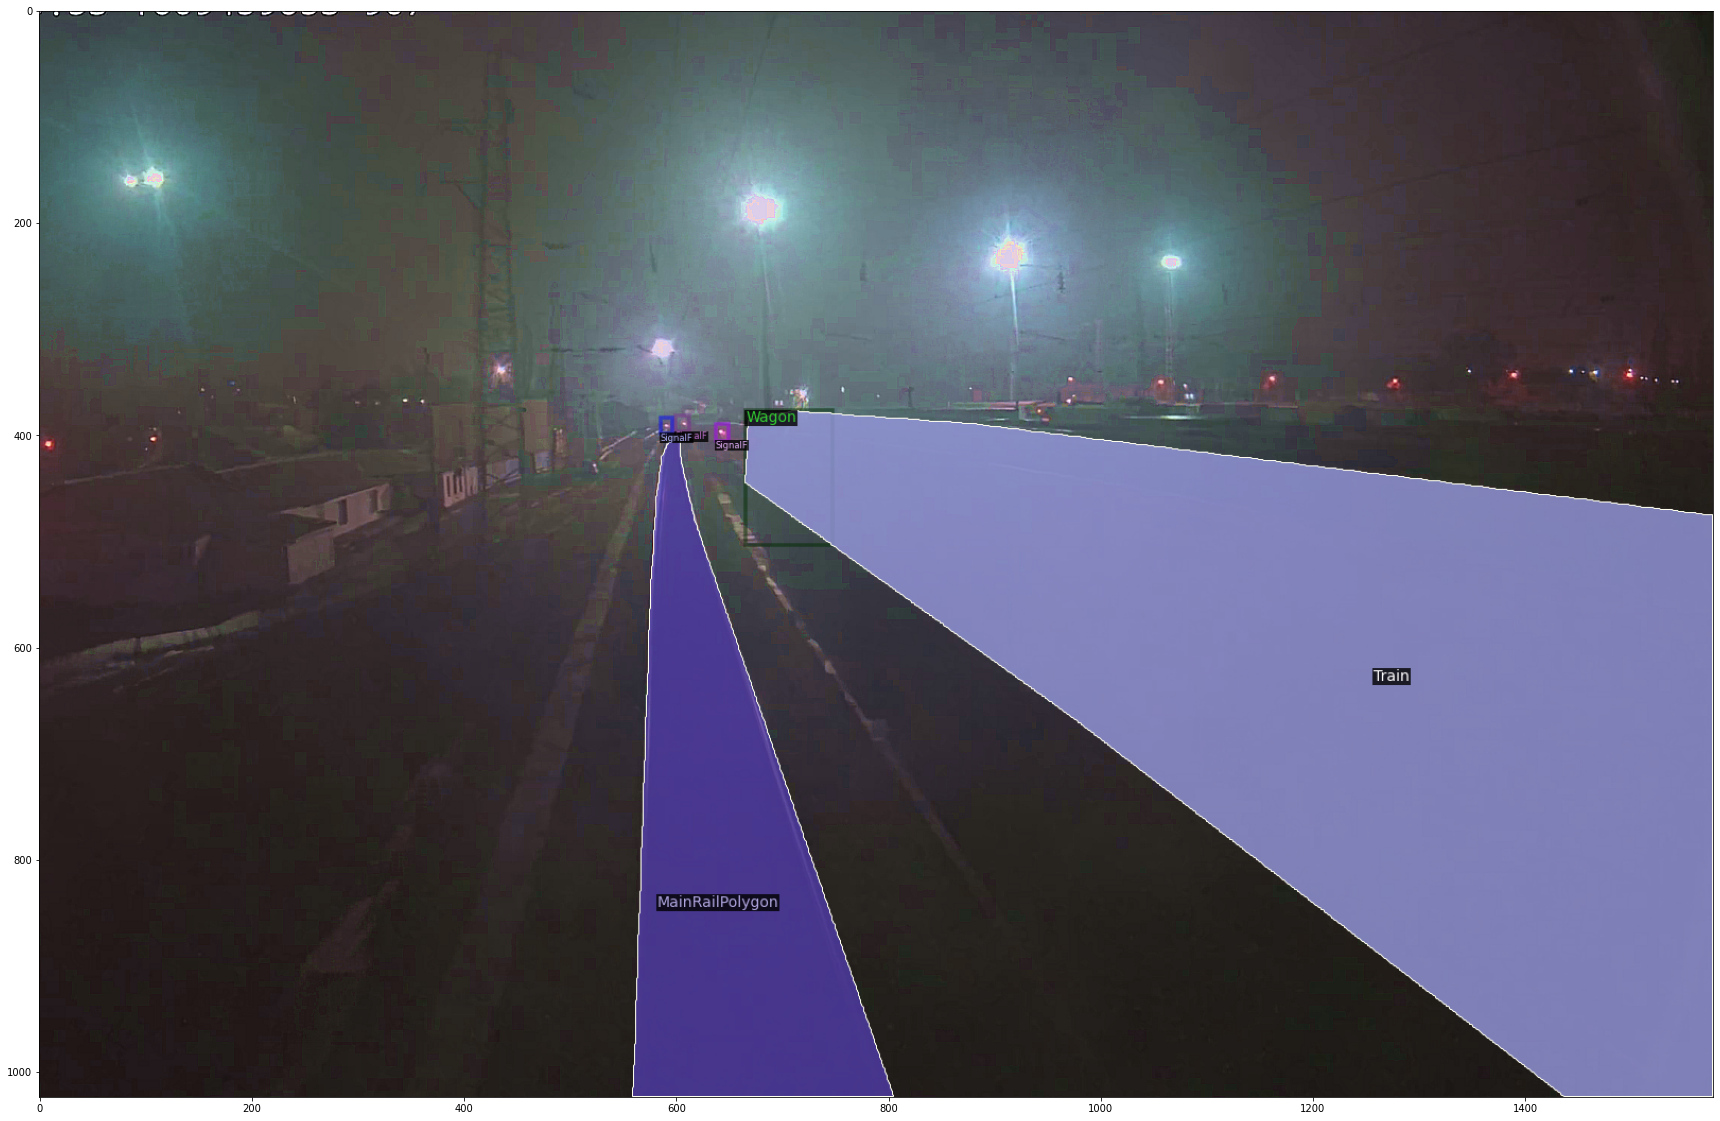

In [15]:
batch = next(dataloader_it)
_ = visualize_batch_item(batch[0], metadata)

## Predictions

In [9]:
trainer = Trainer(cfg)

WARNING [10/24 17:08:29 d2.modeling.meta_arch.panoptic_fpn]: PANOPTIC_FPN.COMBINED.ENABLED is no longer used.  model.inference(do_postprocess=) should be used to toggle postprocessing.
[10/24 17:08:34 d2.engine.defaults]: Model:
MyPanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv

In [43]:
trainer.model.eval()
with torch.no_grad():
    predictions = trainer.model.inference(batch)
    instances = predictions[0]["instances"]
    sem_seg = predictions[0]["sem_seg"]
    sem_seg = torch.argmax(sem_seg, axis=0)
    image = batch[0]["image"]
    image = image[None, ...]
    image = F.interpolate(image, size=(batch[0]["height"], batch[0]["width"]), mode="nearest")[0]
preds_item = {"image": image, "instances": instances, "sem_seg": sem_seg}

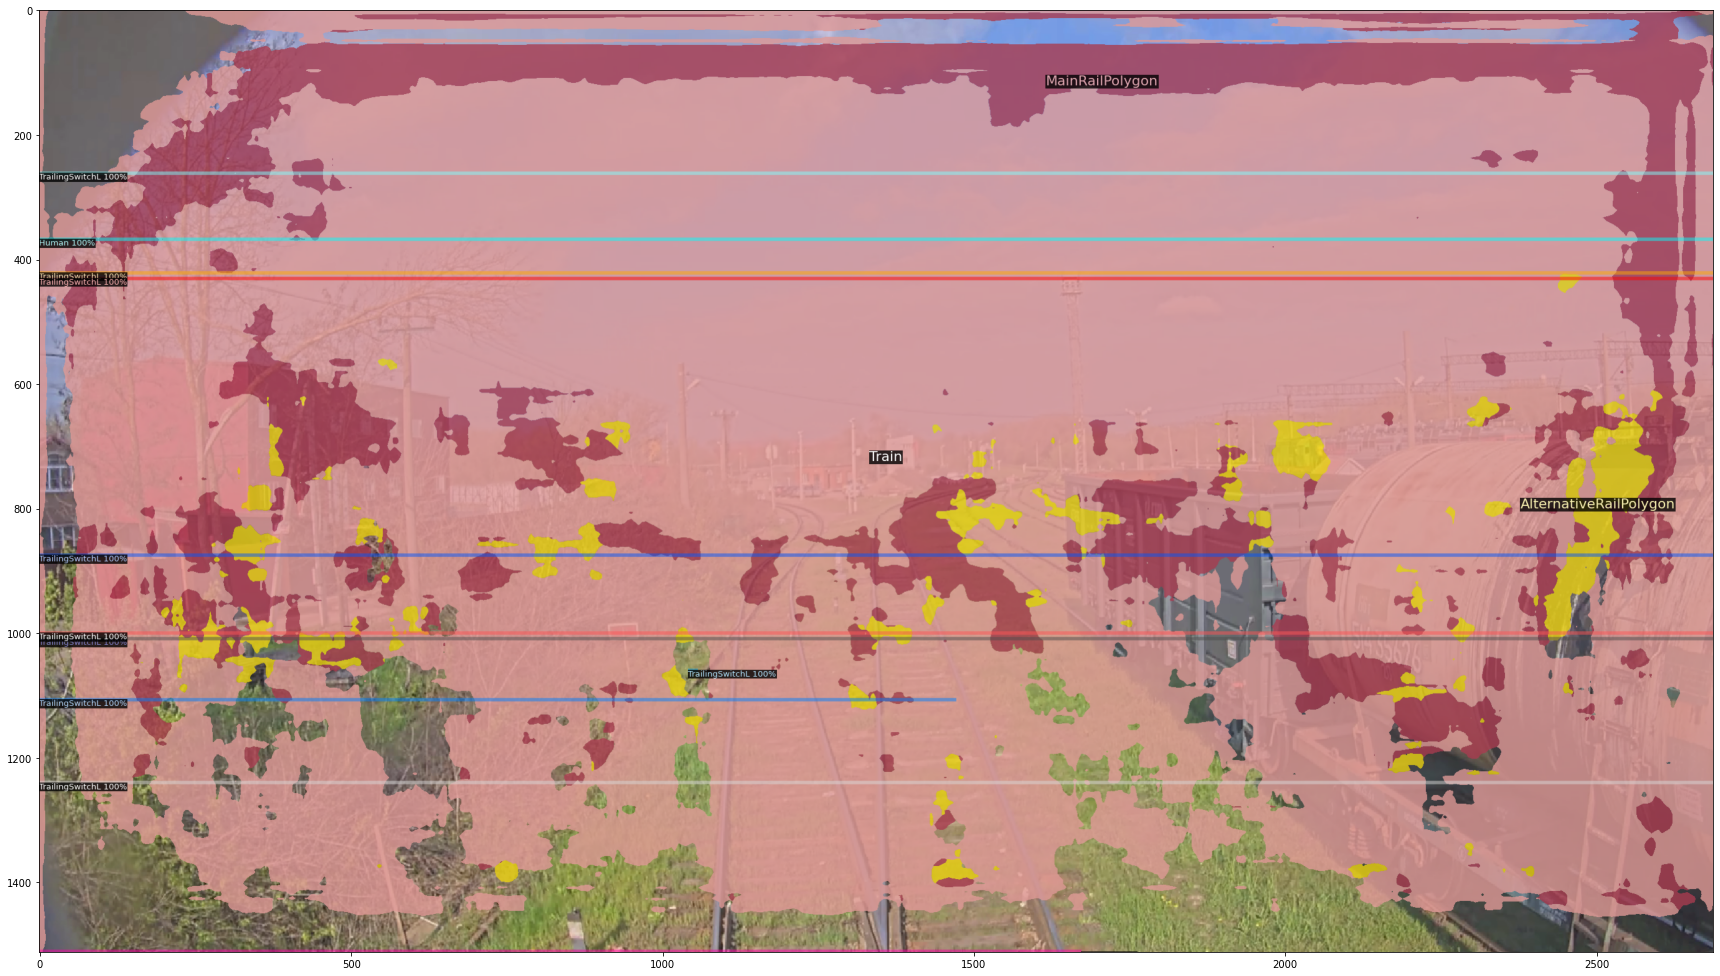

In [44]:
_ = visualize_batch_item(preds_item, metadata)